# Optimizing Stock Portfolio Allocation <a class='tocSkip'>


## Installing Packages in Python

* Default package source for `pip` command is Python Package Index (PyPI)  
    e.g., https://pypi.org/project/yfinance/
* Can also install from github repository: 
    https://pypi.org/project/yfinance/

In [1]:
# install from pypi
!pip install yfinance

In [2]:
# install from github
#!pip install git+https://github.com/ranaroussi/yfinance

In [11]:
! pip list

In [2]:
!pip install cvxpy

In [3]:
import pandas as pd
import numpy as np
import pickle
import cvxpy
import warnings
warnings.filterwarnings("ignore")

## Introduction to Portfolio Theory

### Stock Prices vs. Returns 

* Model stock returns as random variables
* Returns depend on change in stock prices:  
    $$ R_t = \frac{P_t - P_{t-1}}{P_{t-1}} = \frac{P_t}{P_{t-1}} - 1 $$

* Linear approximation of $\log(1+x)\approx x$ when $x$ is small. 
* Since daily stock returns are small,
$$ R_t \approx \log(1 + R_t) = \log\left(\frac{P_t}{P_{t-1}}\right) = \log(P_t) - \log(P_{t-1})$$

* Compute the log-returns then difference of log prices (converting data)

### Modeling Stock Returns

* In classical portfolio theory, stock returns are normally distributed
* Daily returns of two stocks: $R_A$ and $R_B$ of two stocks $A$ and $B$
* Jointly normally distributed: bivariate normal distribution: 
$$\begin{aligned}
\begin{pmatrix}
R_A\\ R_B
\end{pmatrix}
\sim
N\left(
\begin{pmatrix}
\mu_A\\ \mu_B
\end{pmatrix},
\begin{pmatrix}
\sigma_A^2 & \sigma_{AB}\\
\sigma_{AB} & \sigma_B^2
\end{pmatrix}
\right)
\end{aligned}$$

* Marginal distributions: 
$$R_A \sim N(\mu_A,\sigma_A^2) \text{, and } R_B \sim N(\mu_B,\sigma_B^2),$$
* Covariance and correlation are
$$\sigma_\text{AB} = \text{Cov}(R_A,R_B) \text{, and } \rho_\text{AB} = \frac{\sigma_\text{AB}}{\sigma_A\sigma_B}$$

### Modeling Portfolio Returns

* Two-stock portfolio: Return for the portfolio $R_p$ is 
$$R_p = R_A x_A + R_B x_B,$$
* Allocations: $x_A$ and $x_B$ are proportions of stocks $A$ and $B$ such that  
$$x_A + x_B = 1$$

* $R_p$ is also normally distributed with following mean and variance:
$$\begin{aligned}
\mu_p &= \text{E}(R_p) \\
    &= \text{E}(R_B)\, x_A + \text{E}(R_B)\, x_B\\
    &= \mu_A x_A + \mu_B x_B\\
\sigma_p^2 &= \text{Var}(R_p) \\
    &= \text{E}\left((R_p - \text{E}(R_p))^2\right) \\
    &= \sigma_A^2\,x_A^2 + \sigma_B^2\,x_B^2 + 2\sigma_{AB}x_A x_B.
\end{aligned}
$$
Note that $\sigma_{AB} = \rho_{AB}\sigma_A\sigma_B$.
* Distribution of the portfolio return is
$$ R_p \sim N(\mu_p, \sigma_p^2) $$

### Hedging Portfolio Risk

* Mean return ($\mu_p$): weighted average of returns
* Risk ($\sigma_p^2$):  Risk of $p$ can be decreased if $\rho<0$
* Hedge risk by having negatively correlated stocks

## Toy Example: Simulating $R_A$ and $R_B$

* $R_A\sim N(0.15, 0.1^2)$ and $R_B\sim N(0.1, 0.05^2)$
* Correlation: $\rho_{AB} = -0.15$
* Portfolio weight distributed evenly: i.e. $x_A = x_B = 0.5$

In [4]:
# Dictionaries
A = {'mu': 0.15, 'sig': 0.1,  'proportion': 0.5}
B = {'mu': 0.1,  'sig': 0.05, 'proportion': 0.5}

### Generate random returns

In [5]:
def simulate_returns(A, B, correlation, size=100):
    
    from numpy import sqrt
    from numpy.random import multivariate_normal
    from pandas import DataFrame
    
    # what could go wrong with rounding errors?
    assert(A['proportion'] + B['proportion'] == 1) 

    # construct bivariate normal random variable
    mu = [A['mu'], B['mu']]
    sigma = [[A['sig']**2, correlation*A['sig']*B['sig']],
             [correlation*A['sig']*B['sig'], B['sig']**2]]
    
    # get random observations
    R = multivariate_normal(mu, sigma, size)
    Rp = R[:,0]*A['proportion'] + R[:,1]*B['proportion']
    
    # simulated returns
    R = np.hstack((R, Rp.reshape((-1,1))))
    
    # theoretical properties of portfolio returns
    p = {
        'mu': A['mu']*A['proportion'] + B['mu']*B['proportion'],
        'sig': sqrt(
            A['sig']**2*A['proportion']**2 + B['sig']**2*B['proportion']**2 
            + 2*correlation*A['sig']*B['sig']*A['proportion']*B['proportion'])
        }
    
    return p, DataFrame(R, columns=['A', 'B', 'p'])

### Empirical Returns

In [6]:
A = {'mu': 0.15, 'sig': 0.1,  'proportion': 0.5}
B = {'mu': 0.1,  'sig': 0.05, 'proportion': 0.5}

p, R = simulate_returns(A, B, -0.9, 10000)

print('A: mean = %1.2f, std = %1.4f' % (R.A.mean(), R.A.std()))
print('B: mean = %1.2f, std = %1.4f' % (R.B.mean(), R.B.std()))
print('p: mean = %1.2f, std = %1.4f' % (R.p.mean(), R.p.std()))

print('cor(R_A, R_B) = %1.4f' % np.corrcoef(R.A, R.B)[1,0])

A: mean = 0.15, std = 0.0990
B: mean = 0.10, std = 0.0497
p: mean = 0.13, std = 0.0293
cor(R_A, R_B) = -0.8979


### Empirical Portfolio Returns

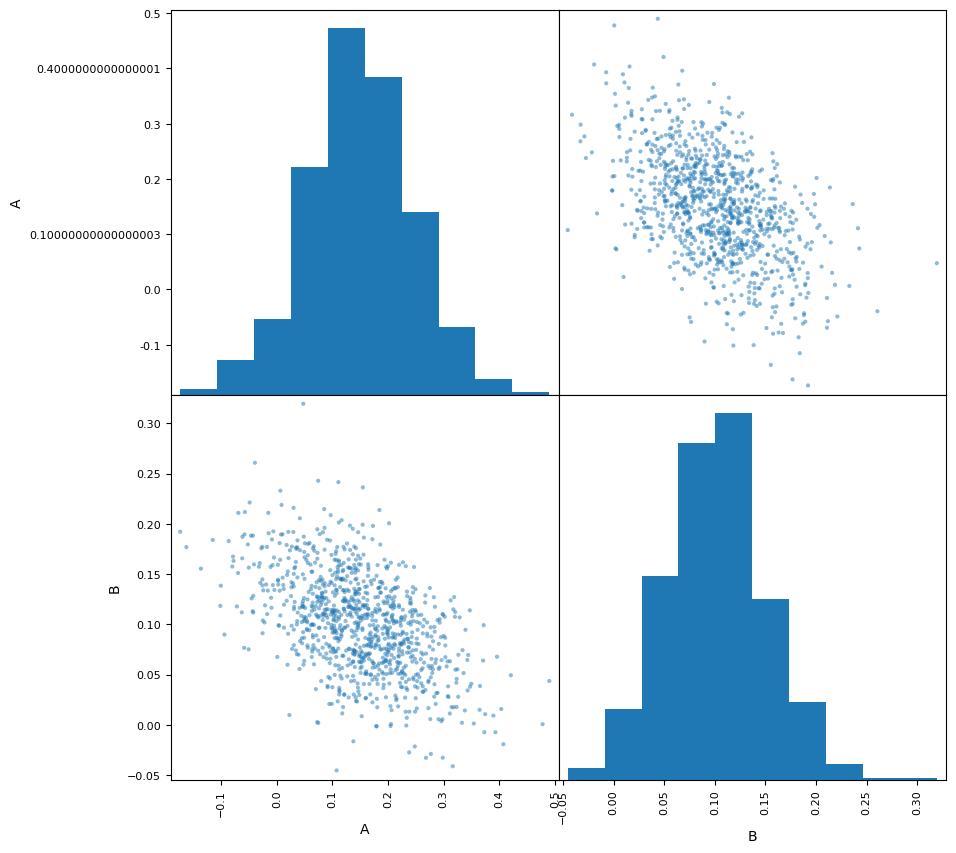

In [7]:
p, R = simulate_returns(A, B, -0.5, 1000)
pd.plotting.scatter_matrix(R.loc[:,['A','B']], figsize=(10,10));

### Theoretical returns

Calculate the volatility ($\sigma^2$) and expected returns ($\mu$):

In [8]:
print('A: mean = %1.2f, std = %1.4f' % (A['mu'], A['sig']))
print('B: mean = %1.2f, std = %1.4f' % (B['mu'], B['sig']))
print('p: mean = %1.2f, std = %1.4f' % (p['mu'], p['sig']))

A: mean = 0.15, std = 0.1000
B: mean = 0.10, std = 0.0500
p: mean = 0.12, std = 0.0433


### Independent Portfolio Theoretical returns

If stocks A and B were independent

In [9]:
p, R = simulate_returns(A, B, -0.9, 10000)
print('A: mean = %1.2f, std = %1.4f' % (A['mu'], A['sig']))
print('B: mean = %1.2f, std = %1.4f' % (B['mu'], B['sig']))
print('')
print('p: mean = %1.2f, std = %1.4f (if A and B are correlated )' % (p['mu'], p['sig']))
print('p: mean = %1.2f, std = %1.4f (if A and B are independent)' % (p['mu'], np.sqrt(0.5**2*A['sig']**2 + 0.5**2*B['sig']**2)))

A: mean = 0.15, std = 0.1000
B: mean = 0.10, std = 0.0500

p: mean = 0.12, std = 0.0296 (if A and B are correlated )
p: mean = 0.12, std = 0.0559 (if A and B are independent)


In [10]:
# Alternatively we can simulate uncorrelated stocks:
p, R = simulate_returns(A, B, 0, 10000)
print('p: mean = %1.2f, std = %1.4f (if A and B are independent )' % (p['mu'], p['sig']))

p: mean = 0.12, std = 0.0559 (if A and B are independent )


#### Empirical (Data) Properties 

In [11]:
print('A: mean = %1.2f, std = %1.4f' % (R.A.mean(), R.A.std()))
print('B: mean = %1.2f, std = %1.4f' % (R.B.mean(), R.B.std()))
print('p: mean = %1.2f, std = %1.4f' % (R.p.mean(), R.p.std()))
print('corr(A, B) = %1.4f' % np.corrcoef(R.A, R.B)[0,1])

A: mean = 0.15, std = 0.1006
B: mean = 0.10, std = 0.0501
p: mean = 0.13, std = 0.0562
corr(A, B) = 0.0019


### Efficient frontier of portfolios

* Consider all values of $x_A$ and $x_B$

* For each combination, compute $\mu_p$ and $\sigma_p^2$.

In [12]:
xa = np.linspace(-1, 2, num=101)
pf = pd.DataFrame({'xa':xa, 'xb':1-xa})

# pf, R = simulate_returns(A, B, -0.5, 10000)

corr = -0.5
pf['mu'] = A['mu'] * pf.xa + B['mu'] * pf.xb
pf['sig2'] = ((A['sig']**2 * pf.xa**2) + (B['sig']**2 * pf.xb**2) + (2 * corr * A['sig'] * B['sig'] * pf.xa * pf.xb))

In [13]:
pf.head()

,xa,xb,mu,sig2
0,-1.00,2.00,0.0500,0.030000
1,-0.97,1.97,0.0515,0.028666
2,-0.94,1.94,0.0530,0.027363
3,-0.91,1.91,0.0545,0.026092
4,-0.88,1.88,0.0560,0.024852


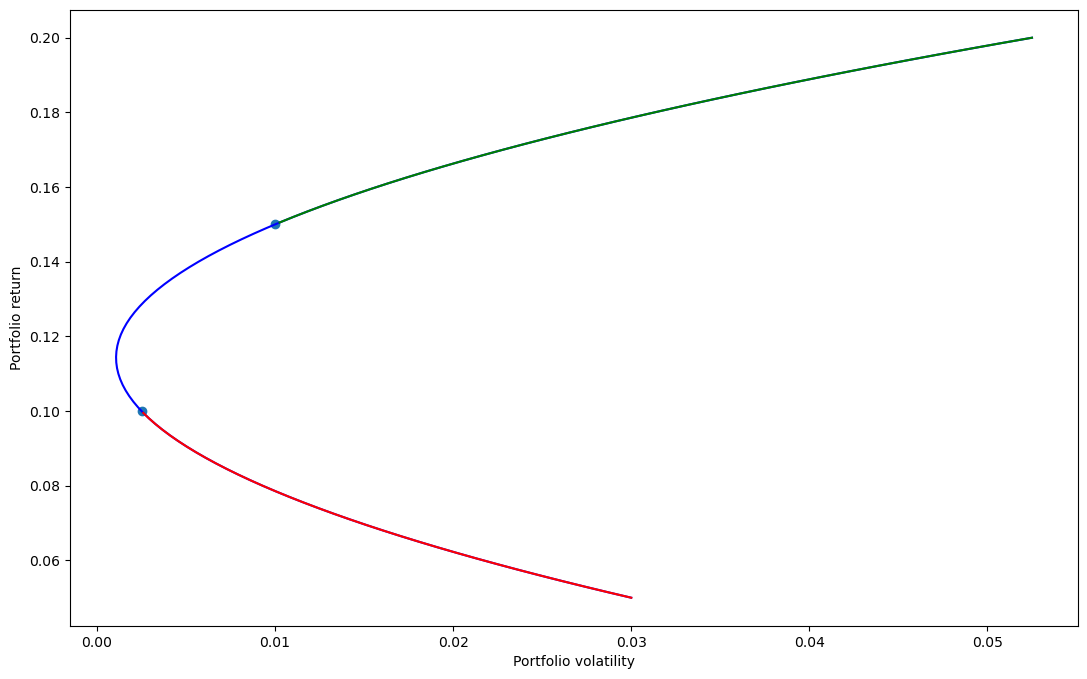

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(13, 8))
plt.plot(pf.sig2, pf.mu, color='b')
plt.plot(pf.sig2[pf.xa<0], pf.mu[pf.xa<0], color='r') # sell stock A to fund purchase of stock B
plt.plot(pf.sig2[pf.xb<0], pf.mu[pf.xb<0], color='g') # sell stock B to fund purchase of stock A
plt.scatter([A['sig']**2, B['sig']**2], [A['mu'], B['mu']])
ax.set_xlabel('Portfolio volatility')
ax.set_ylabel('Portfolio return')
plt.show(p)

* Line is called efficient frontier
* Represents the lower boundary of achievable volatility
* Return and volatility of $A$ and $B$

#### Long and short positions

* Note that `xa` can be negative
* Positive $x_A$ : _long position_ for stock A and indicates a purchase
* Negative $x_A$ : _short position_ stock A and indicates a sale
* _You are selling stocks that you do not own with the expectation that the price of the stock will fall_
* Shorting allows for higher long positions on other stocks.

#### Minimum variance portfolio (MVP)

What is the point at the tip of the parabola? This point indicates what is called the minimum variance portfolio that, regardless of the return, has the minimum volatility. Minimum variance portfolio (MVP) has the minimum volatility of any portfolio achievable.

It can be shown that minimum variance portfolio would have the following allocation $x_A$:

$$x_A = \frac{\sigma_B^2-\sigma_\text{AB}^2}{\sigma_A^2 + \sigma_B^2 – \sigma_\text{AB}^2}$$

The mathematical problem to solve for the minimum variance portfolio can be stated as follows:
$$ \min_{x_A,x_B}\ \ \sigma_p^2 = \sigma_A^2 x_A^2 + \sigma_B^2 x_B^2 + \sigma_{AB} x_A x_B\\
\text{such that }x_A + x_B = 1$$
Here, $\sigma_p^2 = \sigma_A^2 x_A^2 + \sigma_B^2 x_B^2 + \sigma_{AB} x_A x_B$ is called the objective function, and $x_A + x_B = 1$ is called the constraint.

The constraint has to be satisfied exactly, and objective wants to be minimized with the freedom of changing the values of $x_A$ and $x_B$.

### Using `cvxpy` for numerical optimization

Calculating analytical solutions is not always possible. There are ways to compute solutions numerically. Although out of scope of our class, a large field in applied math called optimization. The tools from this area allow us to compute solutions for problems such as the one we have here. (For more information, visit the [CVXPY](https://www.cvxpy.org/) website)

### Higher dimensional portfolios

In higher dimensions, the portfolio equantion is written in terms of vectors and matrices. For example, suppose we construct a portfolio consisting of $s$-assets. The portfolio allocation can be written as,
$$\mathbf{1}^\intercal x = 1,$$
where $x$ is an $s$-vector whose sum adds up to 1: i.e., $x_1 + x_2 + \cdots + x_s = 1$.

The portfolio volatility in matrix-vector form looks like:
$$
\begin{pmatrix}x_1 & x_2 & \cdots & x_s\end{pmatrix}
\begin{pmatrix}
\sigma_1^2 & \sigma_{12} & \cdots & \sigma_{1s}\\
\sigma_{21} & \sigma_2^2 & \cdots & \sigma_{2s}\\
\vdots & \vdots & & \vdots \\
\sigma_{s1} & \sigma_{s2} & \cdots & \sigma_s^2\\
\end{pmatrix}
\begin{pmatrix}x_1 \\ x_2 \\ \vdots \\ x_s\end{pmatrix}.
$$
To verify the two stock example result, we check $\sigma_p^2$:
$$
\sigma_p^2 = \begin{pmatrix}x_1 & x_2\end{pmatrix}
\begin{pmatrix}
\sigma_1^2 & \sigma_{12}\\
\sigma_{21} & \sigma_2^2\\
\end{pmatrix}
\begin{pmatrix}x_1 \\ x_2\end{pmatrix} = 
\begin{pmatrix}x_1 & x_2\end{pmatrix}
\begin{pmatrix}
\sigma_1^2 x_1 + \sigma_{12} x_2\\
\sigma_{21} x_1 + \sigma_2^2 x_2\\
\end{pmatrix} = 
\sigma_1^2 x_1^2 + \sigma_2^2 x_2^2 + \sigma_{12} x_1 x_2,
$$
which matches the result from before.

With this notation, we can re-write the problem.

$$ \min_{x\in\mathbb{R}^s}\ \ x^\intercal \Sigma x\\
\text{subject to }\mathbf{1}^\intercal x = 1,$$

It can be shown that the optimal solution to this problem is,
$$
x^* = (\mathbf{1}^\intercal\Sigma^{-1}\mathbf{1})^{-1}\Sigma^{-1}\mathbf{1}
$$.

There are many variations of this problem. In fact the minimum variance portfolio is special case of a more general problem

$$ \min_{x\in\mathbb{R}^s}\ \ x^\intercal \Sigma x\\
\text{subject to }\mu^\intercal x\geq \mu^* \text{, and } \mathbf{1}^\intercal x = 1,$$

Note that in all of the above problems, the measure of $\mu^*$, expected returns, and covariance matrix have to be provided. In practice, these quantities are estimated from data.

## Portfolio Allocation: Dow Jones component stocks

Stock data can have irregularities such as missing data due to stocks being added and removed from the index. Some examples are
* Alcoa Corp. (AA) was removed in 2013
* Apple (AAPL) was added in 2015
* E.I. du Pont de Nemours & Company (DD) was removed and replaced with Dow du Pont (DWDP) as a continuation in 2017

For simplicity the stocks we will use are based on the most recent DJIA constituent companies 

In [35]:
dowjones_components = [
    'AAPL','AXP','BA','BAC','CAT',
    'CSCO','CVX','DD','DIS','GE',
    'HD','IBM','INTC','JNJ',
    'JPM','KO','MCD','MMM',
    'MRK','MSFT','PFE','PG','T',
    'TRV','VZ','WMT','XOM'
]

symbols = pd.read_csv('data/tickers.csv').set_index('code')

import yfinance as yf
rawdata = yf.download(dowjones_components, start="2000-01-01", end="2023-04-30")
rawdata.head()

[*********************100%%**********************]  27 of 27 completed


Price      Adj Close                                                         \
Ticker          AAPL        AXP         BA        BAC        CAT       CSCO   
Date                                                                          
2000-01-03  0.844981  32.854733  25.940289  12.946366  12.861952  36.641254   
2000-01-04  0.773740  31.614206  25.899946  12.177940  12.696634  34.585606   
2000-01-05  0.785063  30.811222  27.513645  12.311582  12.994211  34.479656   
2000-01-06  0.717125  31.438969  27.796049  13.363992  13.655502  33.907463   
2000-01-07  0.751094  31.896685  28.602894  13.013184  14.101857  35.899529   

Price                                                    ...   Volume  \
Ticker            CVX         DD        DIS          GE  ...      MMM   
Date                                                     ...            
2000-01-03  17.139811  29.194963  23.040167  112.386337  ...  2599386   
2000-01-04  17.139811  28.396984  24.389799  107.890823  ...  3245705   
2000-01-05  17.447252  29.318794  25.402020  107.703522  ...  4424482   
2000-01-06  18.190229  30.144287  24.389799  109.143494  ...  7147057   
2000-01-07  18.510487  30.818439  24.004185  113.369652  ...  4905035   

Price                                                                         \
Ticker           MRK      MSFT       PFE       PG         T     TRV       VZ   
Date                                                                           
2000-01-03   6265782  53228400  12873345  4275000   7668476  336400  4663843   
2000-01-04   7894689  54119000  14208974  4270800   9497846  494400  5005878   
2000-01-05   7963018  64059600  12981591  5098400  12035160  736000  6368681   
2000-01-06   4989004  54976600  11115273  6524200   9471366  660400  4705763   
2000-01-07  10871218  62013600  17962163  9832000   7792534  594700  5043907   

Price                           
Ticker           WMT       XOM  
Date                            
2000-01-03  25109700  13458200  
2000-01-04  20235300  14510800  
2000-01-05  21056100  17485000  
2000-01-06  19633500  19461600  
2000-01-07  23930700  16603800  

[5 rows x 162 columns]

In [36]:
rawdata.tail()

Price        Adj Close                                                 \
Ticker            AAPL         AXP          BA        BAC         CAT   
Date                                                                    
2023-04-24  164.229462  158.382339  205.770004  28.845356  219.366409   
2023-04-25  162.679825  153.973801  202.190002  27.953632  214.653732   
2023-04-26  162.669891  153.579285  203.029999  27.565928  212.258102   
2023-04-27  167.288971  156.271759  206.039993  28.002098  210.431915   
2023-04-28  168.550491  159.122009  206.779999  28.380110  214.820633   

Price                                                                ...  \
Ticker           CSCO         CVX         DD         DIS         GE  ...   
Date                                                                 ...   
2023-04-24  45.960049  164.658997  69.117455   99.356186  79.577919  ...   
2023-04-25  45.669102  162.268066  66.609436   97.691612  78.219177  ...   
2023-04-26  45.135696  159.377777  66.002029   96.296165  76.447243  ...   
2023-04-27  45.155090  160.309189  67.305008   99.605377  77.917236  ...   
2023-04-28  45.824272  161.874374  68.304306  102.167030  78.640305  ...   

Price        Volume                                                           \
Ticker          MMM      MRK      MSFT       PFE       PG         T      TRV   
Date                                                                           
2023-04-24  4229056  4299100  26611000  17633700  8109800  60001400  1015700   
2023-04-25  6065394  5662800  45772200  24492400  8341800  46691800  1208700   
2023-04-26  3795386  6607900  64599200  22401400  4843700  42482900  1168200   
2023-04-27  2862148  9975200  46462600  22434000  4805600  36926900  1573700   
2023-04-28  4764505  8049900  36446700  21003600  5754000  40664000  1052700   

Price                                     
Ticker            VZ       WMT       XOM  
Date                                      
2023-04-24  20362500  13579500  15831300  
2023-04-25  24959400  17246700  12179800  
2023-04-26  21499300  12910200  15566100  
2023-04-27  28841000  12861000  16279200  
2023-04-28  19194400  14088600  24374000  

[5 rows x 162 columns]

In [37]:
symbols # full company names

,name
code,
AAPL,Apple Inc (AAPL)
AXP,American Express Co. (AXP)
BA,The Boeing Co. (BA)
BAC,Bank of America Corp. (BAC)
CAT,Caterpillar Inc. (CAT)
CSCO,Cisco Systems Inc. (CSCO)
CVX,Chevron Corporation (CVX)
DD,E.I. du Pont de Nemours and Co. (DD)
DIS,Disney (Walt) Co. (The) (DIS)


## Data Format

### Hierarchical Indexing

* Column indexing is hierarchical
* Adjusted close, close, high, low, open, and volume are given for each stock symbol

In [38]:
rawdata.columns.levels

FrozenList([['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume'], ['AAPL', 'AXP', 'BA', 'BAC', 'CAT', 'CSCO', 'CVX', 'DD', 'DIS', 'GE', 'HD', 'IBM', 'INTC', 'JNJ', 'JPM', 'KO', 'MCD', 'MMM', 'MRK', 'MSFT', 'PFE', 'PG', 'T', 'TRV', 'VZ', 'WMT', 'XOM']])

* Column levels can be named:

In [39]:
rawdata.columns = rawdata.columns.set_names(['Value', 'Symbol'])
rawdata.head()

Value      Adj Close                                                         \
Symbol          AAPL        AXP         BA        BAC        CAT       CSCO   
Date                                                                          
2000-01-03  0.844981  32.854733  25.940289  12.946366  12.861952  36.641254   
2000-01-04  0.773740  31.614206  25.899946  12.177940  12.696634  34.585606   
2000-01-05  0.785063  30.811222  27.513645  12.311582  12.994211  34.479656   
2000-01-06  0.717125  31.438969  27.796049  13.363992  13.655502  33.907463   
2000-01-07  0.751094  31.896685  28.602894  13.013184  14.101857  35.899529   

Value                                                    ...   Volume  \
Symbol            CVX         DD        DIS          GE  ...      MMM   
Date                                                     ...            
2000-01-03  17.139811  29.194963  23.040167  112.386337  ...  2599386   
2000-01-04  17.139811  28.396984  24.389799  107.890823  ...  3245705   
2000-01-05  17.447252  29.318794  25.402020  107.703522  ...  4424482   
2000-01-06  18.190229  30.144287  24.389799  109.143494  ...  7147057   
2000-01-07  18.510487  30.818439  24.004185  113.369652  ...  4905035   

Value                                                                         \
Symbol           MRK      MSFT       PFE       PG         T     TRV       VZ   
Date                                                                           
2000-01-03   6265782  53228400  12873345  4275000   7668476  336400  4663843   
2000-01-04   7894689  54119000  14208974  4270800   9497846  494400  5005878   
2000-01-05   7963018  64059600  12981591  5098400  12035160  736000  6368681   
2000-01-06   4989004  54976600  11115273  6524200   9471366  660400  4705763   
2000-01-07  10871218  62013600  17962163  9832000   7792534  594700  5043907   

Value                           
Symbol           WMT       XOM  
Date                            
2000-01-03  25109700  13458200  
2000-01-04  20235300  14510800  
2000-01-05  21056100  17485000  
2000-01-06  19633500  19461600  
2000-01-07  23930700  16603800  

[5 rows x 162 columns]

* Subsetting first level of hierarchical indexing: `Adj Close`

In [40]:
rawdata['Adj Close'].head()

Symbol,AAPL,AXP,BA,BAC,CAT,CSCO,CVX,DD,DIS,GE,...,MMM,MRK,MSFT,PFE,PG,T,TRV,VZ,WMT,XOM
Date,,,,,,,,,,,,,,,,,,,,,
2000-01-03,0.844981,32.854733,25.940289,12.946366,12.861952,36.641254,17.139811,29.194963,23.040167,112.386337,...,17.557301,26.704506,36.065563,13.061065,28.069090,6.792761,17.910801,17.185566,14.469358,18.328695
2000-01-04,0.773740,31.614206,25.899946,12.177940,12.696634,34.585606,17.139811,28.396984,24.389799,107.890823,...,16.859659,25.766645,34.847271,12.574481,27.528994,6.395309,17.673359,16.630033,13.927945,17.977631
2000-01-05,0.785063,30.811222,27.513645,12.311582,12.994211,34.479656,17.447252,29.318794,25.402020,107.703522,...,17.348009,26.778534,35.214680,12.779357,27.005247,6.494676,17.537663,17.185566,13.643696,18.957682
2000-01-06,0.717125,31.438969,27.796049,13.363992,13.655502,33.907463,18.190229,30.144287,24.389799,109.143494,...,18.743286,27.000677,34.035080,13.240336,28.249134,6.368837,17.876890,17.098272,13.792586,19.937765
2000-01-07,0.751094,31.896685,28.602894,13.013184,14.101857,35.899529,18.510487,30.818439,24.004185,113.369652,...,19.115368,29.592155,34.479843,14.136687,30.507763,6.423426,18.589251,16.972017,14.834812,19.879250


* Subsetting first level of hierarchical indexing: `Volume`

In [53]:
rawdata.loc[:, 'Volume'].head()

Symbol,AAPL,AXP,BA,BAC,CAT,CSCO,CVX,DD,DIS,GE,...,MMM,MRK,MSFT,PFE,PG,T,TRV,VZ,WMT,XOM
Date,,,,,,,,,,,,,,,,,,,,,
2000-01-03,535796800,6471267,2638200,13705800,5055000,53076000,4387600,1296100,8402230,4605131,...,2599386,6265782,53228400,12873345,4275000,7668476,336400,4663843,25109700,13458200
2000-01-04,512377600,10440877,3592100,27293400,6181400,50805600,3702400,2073676,16051191,4615898,...,3245705,7894689,54119000,14208974,4270800,9497846,494400,5005878,20235300,14510800
2000-01-05,778321600,8646293,7631700,22855600,6398600,68524000,5567600,3653278,19823822,5694973,...,4424482,7963018,64059600,12981591,5098400,12035160,736000,6368681,21056100,17485000
2000-01-06,767972800,10990975,4922200,17307000,5140600,48242600,4353400,4885511,7903193,4146783,...,7147057,4989004,54976600,11115273,6524200,9471366,660400,4705763,19633500,19461600
2000-01-07,460734400,6016452,6008300,11632800,6360200,62260600,4487400,3469265,6773543,4202747,...,4905035,10871218,62013600,17962163,9832000,7792534,594700,5043907,23930700,16603800


* Subsetting second level is slightly harder: `AAPL`

In [54]:
idx = pd.IndexSlice
rawdata.loc[:, idx[:, 'AAPL']].head()

Value,Adj Close,Close,High,Low,Open,Volume
Symbol,AAPL,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,,
2000-01-03,0.844981,0.999442,1.004464,0.907924,0.936384,535796800
2000-01-04,0.773740,0.915179,0.987723,0.903460,0.966518,512377600
2000-01-05,0.785063,0.928571,0.987165,0.919643,0.926339,778321600
2000-01-06,0.717125,0.848214,0.955357,0.848214,0.947545,767972800
2000-01-07,0.751094,0.888393,0.901786,0.852679,0.861607,460734400


* Subsetting `Open`, `High`, `Low`, and `Close` (OHLC) for `AAPL`:

In [55]:
aapl = rawdata.loc[:, idx['Close':'Open', 'AAPL']]
aapl.head()

Value,Close,High,Low,Open
Symbol,AAPL,AAPL,AAPL,AAPL
Date,,,,
2000-01-03,0.999442,1.004464,0.907924,0.936384
2000-01-04,0.915179,0.987723,0.903460,0.966518
2000-01-05,0.928571,0.987165,0.919643,0.926339
2000-01-06,0.848214,0.955357,0.848214,0.947545
2000-01-07,0.888393,0.901786,0.852679,0.861607


* Drop redudant index level, `AAPL`:

In [56]:
aapl = rawdata.loc[:, idx['Close':'Open', 'AAPL']].droplevel('Symbol', axis=1).tail(60)
aapl.head()

Value,Close,High,Low,Open
Date,,,,
2023-02-02,150.820007,151.179993,148.169998,148.899994
2023-02-03,154.500000,157.380005,147.830002,148.029999
2023-02-06,151.729996,153.100006,150.779999,152.570007
2023-02-07,154.649994,155.229996,150.639999,150.639999
2023-02-08,151.919998,154.580002,151.169998,153.880005


### Example Figure: Candlestick Chart for 3M

In [57]:
mmm = rawdata.loc[:, idx['Close':'Open', 'MMM']].droplevel('Symbol', axis=1).tail(60)

import altair as alt

open_close_color = alt.condition(
    "datum.Open <= datum.Close",
    alt.value("#06982d"), # green for increase
    alt.value("#ae1325"), # red for decrease
) 

base = alt.Chart(mmm.reset_index()).encode(
    alt.X('Date:T',
          axis=alt.Axis(
              format='%m-%d-%Y',
              labelAngle=-90)
    ),
    color=open_close_color
)

rule = base.mark_rule().encode(
    alt.Y(
        'Low:Q',
        title='Price',
        scale=alt.Scale(zero=False),
    ),
    alt.Y2('High:Q')
)

bar = base.mark_bar().encode(
    alt.Y('Open:Q'),
    alt.Y2('Close:Q')
)

rule + bar

alt.LayerChart(...)

In [58]:
 rawdata.head()

Value      Adj Close                                                         \
Symbol          AAPL        AXP         BA        BAC        CAT       CSCO   
Date                                                                          
2000-01-03  0.844981  32.854733  25.940289  12.946366  12.861952  36.641254   
2000-01-04  0.773740  31.614206  25.899946  12.177940  12.696634  34.585606   
2000-01-05  0.785063  30.811222  27.513645  12.311582  12.994211  34.479656   
2000-01-06  0.717125  31.438969  27.796049  13.363992  13.655502  33.907463   
2000-01-07  0.751094  31.896685  28.602894  13.013184  14.101857  35.899529   

Value                                                    ...   Volume  \
Symbol            CVX         DD        DIS          GE  ...      MMM   
Date                                                     ...            
2000-01-03  17.139811  29.194963  23.040167  112.386337  ...  2599386   
2000-01-04  17.139811  28.396984  24.389799  107.890823  ...  3245705   
2000-01-05  17.447252  29.318794  25.402020  107.703522  ...  4424482   
2000-01-06  18.190229  30.144287  24.389799  109.143494  ...  7147057   
2000-01-07  18.510487  30.818439  24.004185  113.369652  ...  4905035   

Value                                                                         \
Symbol           MRK      MSFT       PFE       PG         T     TRV       VZ   
Date                                                                           
2000-01-03   6265782  53228400  12873345  4275000   7668476  336400  4663843   
2000-01-04   7894689  54119000  14208974  4270800   9497846  494400  5005878   
2000-01-05   7963018  64059600  12981591  5098400  12035160  736000  6368681   
2000-01-06   4989004  54976600  11115273  6524200   9471366  660400  4705763   
2000-01-07  10871218  62013600  17962163  9832000   7792534  594700  5043907   

Value                           
Symbol           WMT       XOM  
Date                            
2000-01-03  25109700  13458200  
2000-01-04  20235300  14510800  
2000-01-05  21056100  17485000  
2000-01-06  19633500  19461600  
2000-01-07  23930700  16603800  

[5 rows x 162 columns]

### Example Figure: Adjusted close prices

In [59]:
first10 = rawdata.loc[:, idx['Adj Close', ['MMM', 'MRK', 'PFE', 'PG', 'JNJ']]].tail(60)
first10.head()

Value       Adj Close                                               
Symbol            MMM         MRK        PFE          PG         JNJ
Date                                                                
2023-02-02  91.916786  100.009537  42.170307  137.755112  159.453934
2023-02-03  89.777229   99.506882  41.904007  138.181458  158.558136
2023-02-06  89.020744  100.560516  41.618683  137.009018  157.354080
2023-02-07  89.326401  102.155495  41.457008  135.671860  157.392593
2023-02-08  88.065598  103.083481  41.827923  134.266907  157.594879

* Stacking transforms data into long-format:  
    _Note: unstack does the opposite_

In [60]:
healthcare = first10.stack('Symbol')
healthcare

Value               Adj Close
Date       Symbol            
2023-02-02 JNJ     159.453934
           MMM      91.916786
           MRK     100.009537
           PFE      42.170307
           PG      137.755112
...                       ...
2023-04-28 JNJ     158.815689
           MMM      82.454163
           MRK     112.395012
           PFE      36.986988
           PG      152.472504

[300 rows x 1 columns]

In [61]:
base = alt.Chart(healthcare.reset_index()).mark_line().encode(
    x=alt.X('Date:T',
            axis=alt.Axis(
                format='%m-%d-%Y',
                labelAngle=-90)
    ),
    y='Adj Close:Q',
    color='Symbol:N'
)
base

alt.Chart(...)

* Inspect missing values:  

In [62]:
rawdata['Adj Close'].isna().sum(axis=0)

Symbol
AAPL    0
AXP     0
BA      0
BAC     0
CAT     0
CSCO    0
CVX     0
DD      0
DIS     0
GE      0
HD      0
IBM     0
INTC    0
JNJ     0
JPM     0
KO      0
MCD     0
MMM     0
MRK     0
MSFT    0
PFE     0
PG      0
T       0
TRV     0
VZ      0
WMT     0
XOM     0
dtype: int64

In [63]:
anymissing = rawdata['Adj Close'].isna().any(axis=1)
rawdata.loc[anymissing]

Empty DataFrame
Columns: [(Adj Close, AAPL), (Adj Close, AXP), (Adj Close, BA), (Adj Close, BAC), (Adj Close, CAT), (Adj Close, CSCO), (Adj Close, CVX), (Adj Close, DD), (Adj Close, DIS), (Adj Close, GE), (Adj Close, HD), (Adj Close, IBM), (Adj Close, INTC), (Adj Close, JNJ), (Adj Close, JPM), (Adj Close, KO), (Adj Close, MCD), (Adj Close, MMM), (Adj Close, MRK), (Adj Close, MSFT), (Adj Close, PFE), (Adj Close, PG), (Adj Close, T), (Adj Close, TRV), (Adj Close, VZ), (Adj Close, WMT), (Adj Close, XOM), (Close, AAPL), (Close, AXP), (Close, BA), (Close, BAC), (Close, CAT), (Close, CSCO), (Close, CVX), (Close, DD), (Close, DIS), (Close, GE), (Close, HD), (Close, IBM), (Close, INTC), (Close, JNJ), (Close, JPM), (Close, KO), (Close, MCD), (Close, MMM), (Close, MRK), (Close, MSFT), (Close, PFE), (Close, PG), (Close, T), (Close, TRV), (Close, VZ), (Close, WMT), (Close, XOM), (High, AAPL), (High, AXP), (High, BA), (High, BAC), (High, CAT), (High, CSCO), (High, CVX), (High, DD), (High, DIS), (High, GE), (High, HD), (High, IBM), (High, INTC), (High, JNJ), (High, JPM), (High, KO), (High, MCD), (High, MMM), (High, MRK), (High, MSFT), (High, PFE), (High, PG), (High, T), (High, TRV), (High, VZ), (High, WMT), (High, XOM), (Low, AAPL), (Low, AXP), (Low, BA), (Low, BAC), (Low, CAT), (Low, CSCO), (Low, CVX), (Low, DD), (Low, DIS), (Low, GE), (Low, HD), (Low, IBM), (Low, INTC), (Low, JNJ), (Low, JPM), (Low, KO), (Low, MCD), (Low, MMM), (Low, MRK), ...]
Index: []

[0 rows x 162 columns]

* Double check: did we remove all missing values?

In [64]:
(rawdata.isna().sum(axis=None)>0).any()

False

* Reset symbols to what is in `data` variable

In [65]:
symbols = symbols.loc[rawdata.columns.levels[1].to_list()]
symbols

,name
code,
AAPL,Apple Inc (AAPL)
AXP,American Express Co. (AXP)
BA,The Boeing Co. (BA)
BAC,Bank of America Corp. (BAC)
CAT,Caterpillar Inc. (CAT)
CSCO,Cisco Systems Inc. (CSCO)
CVX,Chevron Corporation (CVX)
DD,E.I. du Pont de Nemours and Co. (DD)
DIS,Disney (Walt) Co. (The) (DIS)


In [66]:
rawdata.head()

Value      Adj Close                                                         \
Symbol          AAPL        AXP         BA        BAC        CAT       CSCO   
Date                                                                          
2000-01-03  0.844981  32.854733  25.940289  12.946366  12.861952  36.641254   
2000-01-04  0.773740  31.614206  25.899946  12.177940  12.696634  34.585606   
2000-01-05  0.785063  30.811222  27.513645  12.311582  12.994211  34.479656   
2000-01-06  0.717125  31.438969  27.796049  13.363992  13.655502  33.907463   
2000-01-07  0.751094  31.896685  28.602894  13.013184  14.101857  35.899529   

Value                                                    ...   Volume  \
Symbol            CVX         DD        DIS          GE  ...      MMM   
Date                                                     ...            
2000-01-03  17.139811  29.194963  23.040167  112.386337  ...  2599386   
2000-01-04  17.139811  28.396984  24.389799  107.890823  ...  3245705   
2000-01-05  17.447252  29.318794  25.402020  107.703522  ...  4424482   
2000-01-06  18.190229  30.144287  24.389799  109.143494  ...  7147057   
2000-01-07  18.510487  30.818439  24.004185  113.369652  ...  4905035   

Value                                                                         \
Symbol           MRK      MSFT       PFE       PG         T     TRV       VZ   
Date                                                                           
2000-01-03   6265782  53228400  12873345  4275000   7668476  336400  4663843   
2000-01-04   7894689  54119000  14208974  4270800   9497846  494400  5005878   
2000-01-05   7963018  64059600  12981591  5098400  12035160  736000  6368681   
2000-01-06   4989004  54976600  11115273  6524200   9471366  660400  4705763   
2000-01-07  10871218  62013600  17962163  9832000   7792534  594700  5043907   

Value                           
Symbol           WMT       XOM  
Date                            
2000-01-03  25109700  13458200  
2000-01-04  20235300  14510800  
2000-01-05  21056100  17485000  
2000-01-06  19633500  19461600  
2000-01-07  23930700  16603800  

[5 rows x 162 columns]

### Adjusted Close

* [Adjusted closing prices](https://help.yahoo.com/kb/SLN28256.html) accounts for splits, etc

In [67]:
data = rawdata['Adj Close']
data.head()

Symbol,AAPL,AXP,BA,BAC,CAT,CSCO,CVX,DD,DIS,GE,...,MMM,MRK,MSFT,PFE,PG,T,TRV,VZ,WMT,XOM
Date,,,,,,,,,,,,,,,,,,,,,
2000-01-03,0.844981,32.854733,25.940289,12.946366,12.861952,36.641254,17.139811,29.194963,23.040167,112.386337,...,17.557301,26.704506,36.065563,13.061065,28.069090,6.792761,17.910801,17.185566,14.469358,18.328695
2000-01-04,0.773740,31.614206,25.899946,12.177940,12.696634,34.585606,17.139811,28.396984,24.389799,107.890823,...,16.859659,25.766645,34.847271,12.574481,27.528994,6.395309,17.673359,16.630033,13.927945,17.977631
2000-01-05,0.785063,30.811222,27.513645,12.311582,12.994211,34.479656,17.447252,29.318794,25.402020,107.703522,...,17.348009,26.778534,35.214680,12.779357,27.005247,6.494676,17.537663,17.185566,13.643696,18.957682
2000-01-06,0.717125,31.438969,27.796049,13.363992,13.655502,33.907463,18.190229,30.144287,24.389799,109.143494,...,18.743286,27.000677,34.035080,13.240336,28.249134,6.368837,17.876890,17.098272,13.792586,19.937765
2000-01-07,0.751094,31.896685,28.602894,13.013184,14.101857,35.899529,18.510487,30.818439,24.004185,113.369652,...,19.115368,29.592155,34.479843,14.136687,30.507763,6.423426,18.589251,16.972017,14.834812,19.879250


### Log returns from stock prices

* Data is price per share
* We need daily returns from the prices
* Given the prices $P_t$ and $P_{t-1}$ for time $t$, the return is, 
$$ R_t = \frac{P_t - P_{t-1}}{P_{t-1}} = \frac{P_t}{P_{t-1}} - 1 $$

* Approximation $\log(1+x)\approx x$ is good when $x$ is small
* Since daily returns of stocks are small, calculate as returns,
$$ r_t = \log(1 + R_t) = \log\left(\frac{P_t}{P_{t-1}}\right) = \log(P_t) - \log(P_{t-1})$$
So, in order to compute the log-returns, compute the difference of log prices:

In [68]:
logret = np.log(data).diff()
logret.head()

Symbol,AAPL,AXP,BA,BAC,CAT,CSCO,CVX,DD,DIS,GE,...,MMM,MRK,MSFT,PFE,PG,T,TRV,VZ,WMT,XOM
Date,,,,,,,,,,,,,,,,,,,,,
2000-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-04,-0.088078,-0.038489,-0.001556,-0.061189,-0.012937,-0.057737,0.000000,-0.027713,0.056926,-0.040823,...,-0.040546,-0.035751,-0.034364,-0.037966,-0.019429,-0.060293,-0.013346,-0.032860,-0.038136,-0.019340
2000-01-05,0.014527,-0.025728,0.060441,0.010914,0.023167,-0.003068,0.017778,0.031946,0.040664,-0.001738,...,0.028554,0.038520,0.010488,0.016162,-0.019209,0.015418,-0.007708,0.032860,-0.020620,0.053081
2000-01-06,-0.090514,0.020169,0.010212,0.082023,0.049639,-0.016734,0.041702,0.027767,-0.040664,0.013281,...,0.077358,0.008261,-0.034071,0.035437,0.045032,-0.019566,0.019158,-0.005092,0.010854,0.050406
2000-01-07,0.046281,0.014454,0.028614,-0.026601,0.032164,0.057089,0.017453,0.022118,-0.015937,0.037990,...,0.019657,0.091647,0.012983,0.065505,0.076918,0.008535,0.039075,-0.007411,0.072845,-0.002939


* First time period is NaN since there is no data corresponding to $-1$.

* Note that $100\cdot r_t$% represent daily percentage returns.

### Estimate expected returns

Estimate the daily expected returns by computing the means:

In [69]:
mu = logret[1:].mean()
mu

Symbol
AAPL    0.000903
AXP     0.000269
BA      0.000354
BAC     0.000134
CAT     0.000480
CSCO    0.000038
CVX     0.000383
DD      0.000145
DIS     0.000254
GE     -0.000061
HD      0.000341
IBM     0.000118
INTC    0.000035
JNJ     0.000317
JPM     0.000296
KO      0.000249
MCD     0.000440
MMM     0.000264
MRK     0.000245
MSFT    0.000364
PFE     0.000177
PG      0.000288
T       0.000151
TRV     0.000391
VZ      0.000127
WMT     0.000210
XOM     0.000312
dtype: float64

### Estimate covariance matrix (volatility structure)

Estimate the covarince matrix of returns:

In [70]:
sigma = logret.cov()
sigma

Symbol,AAPL,AXP,BA,BAC,CAT,CSCO,CVX,DD,DIS,GE,...,MMM,MRK,MSFT,PFE,PG,T,TRV,VZ,WMT,XOM
Symbol,,,,,,,,,,,,,,,,,,,,,
AAPL,0.000671,0.000213,0.000168,0.000225,0.000187,0.000279,0.000122,0.000167,0.000175,0.000186,...,0.000125,0.000088,0.000234,0.000089,0.000069,0.000112,0.000133,0.000096,0.000099,0.000116
AXP,0.000213,0.000521,0.000261,0.000432,0.000255,0.000239,0.000201,0.000270,0.000249,0.000288,...,0.000180,0.000135,0.000205,0.000142,0.000104,0.000165,0.000234,0.000138,0.000118,0.000184
BA,0.000168,0.000261,0.000500,0.000263,0.000217,0.000178,0.000186,0.000235,0.000204,0.000242,...,0.000152,0.000106,0.000166,0.000115,0.000085,0.000127,0.000172,0.000099,0.000092,0.000175
BAC,0.000225,0.000432,0.000263,0.000795,0.000290,0.000249,0.000221,0.000312,0.000246,0.000330,...,0.000202,0.000141,0.000206,0.000159,0.000111,0.000175,0.000266,0.000144,0.000116,0.000199
CAT,0.000187,0.000255,0.000217,0.000290,0.000415,0.000192,0.000193,0.000268,0.000185,0.000229,...,0.000179,0.000108,0.000163,0.000117,0.000086,0.000126,0.000167,0.000104,0.000098,0.000182
CSCO,0.000279,0.000239,0.000178,0.000249,0.000192,0.000554,0.000132,0.000192,0.000203,0.000211,...,0.000145,0.000097,0.000255,0.000110,0.000080,0.000132,0.000156,0.000122,0.000111,0.000126
CVX,0.000122,0.000201,0.000186,0.000221,0.000193,0.000132,0.000311,0.000192,0.000151,0.000175,...,0.000125,0.000111,0.000132,0.000108,0.000070,0.000114,0.000154,0.000094,0.000068,0.000249
DD,0.000167,0.000270,0.000235,0.000312,0.000268,0.000192,0.000192,0.000493,0.000200,0.000241,...,0.000187,0.000124,0.000166,0.000129,0.000104,0.000137,0.000183,0.000111,0.000105,0.000179
DIS,0.000175,0.000249,0.000204,0.000246,0.000185,0.000203,0.000151,0.000200,0.000378,0.000205,...,0.000138,0.000101,0.000173,0.000106,0.000079,0.000129,0.000149,0.000114,0.000096,0.000143


### Visualize volatility structure

* Heatmap visualization of covariance and correlation

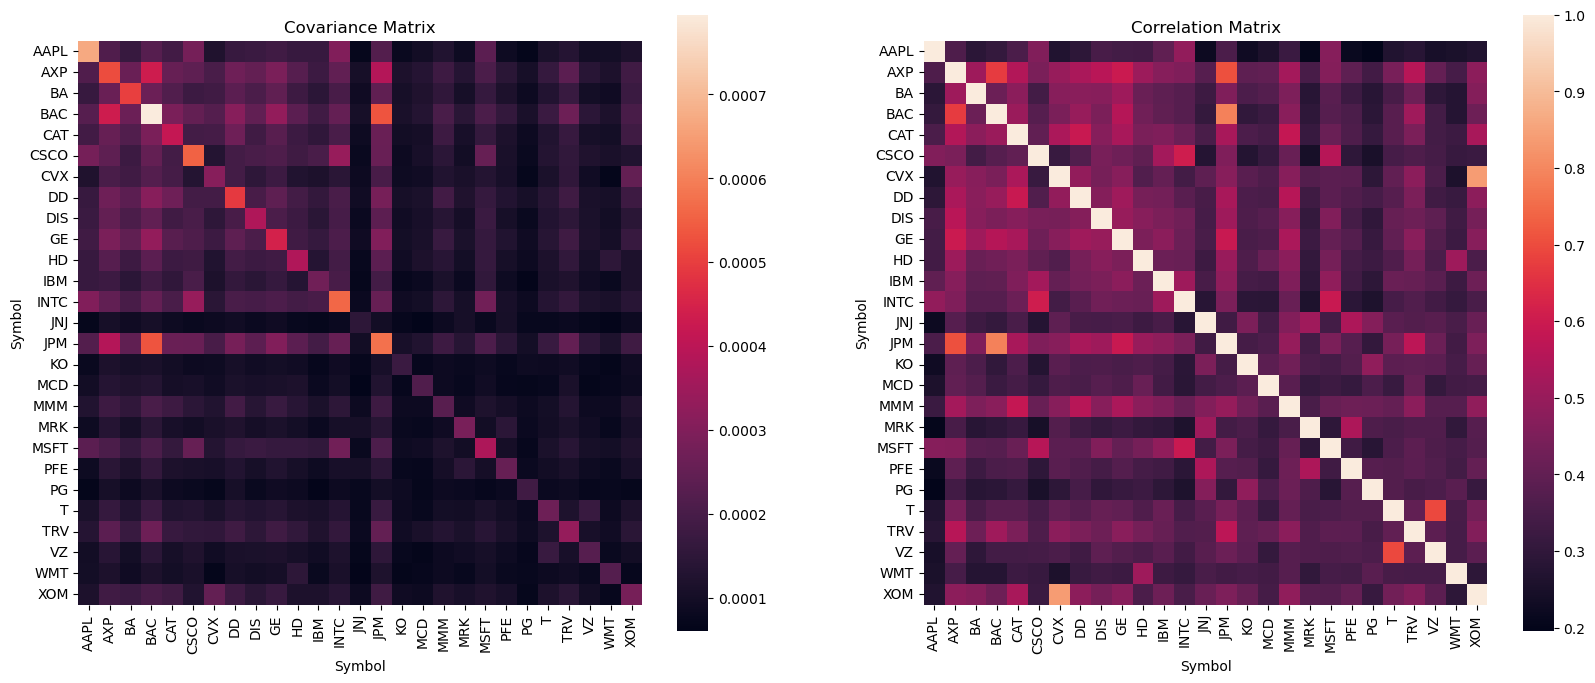

In [71]:
import seaborn as sns
fig, ax = plt.subplots(1, 2, figsize=(20, 8))
sns.heatmap(logret.cov(),  square=True, ax=ax[0]).set_title('Covariance Matrix')
sns.heatmap(logret.corr(), square=True, ax=ax[1]).set_title('Correlation Matrix')
fig.show()

* Reordering variables group similar stocks together

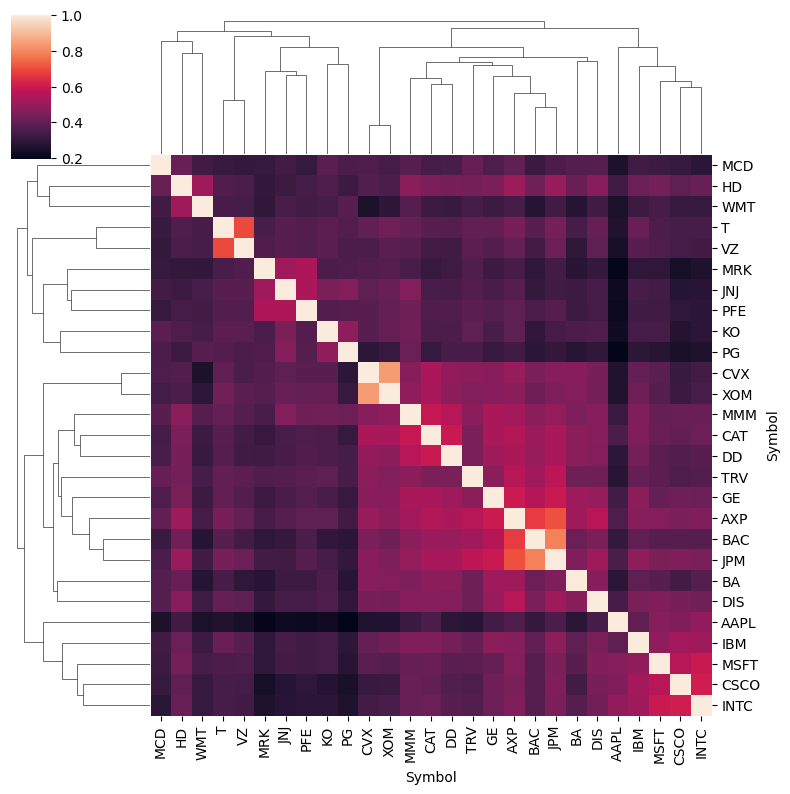

In [72]:
clmap = sns.clustermap(logret.corr(), square=True, figsize=(8, 8));
ordering = clmap.dendrogram_col.reordered_ind # save the hierarchical clustering generated variable ordering

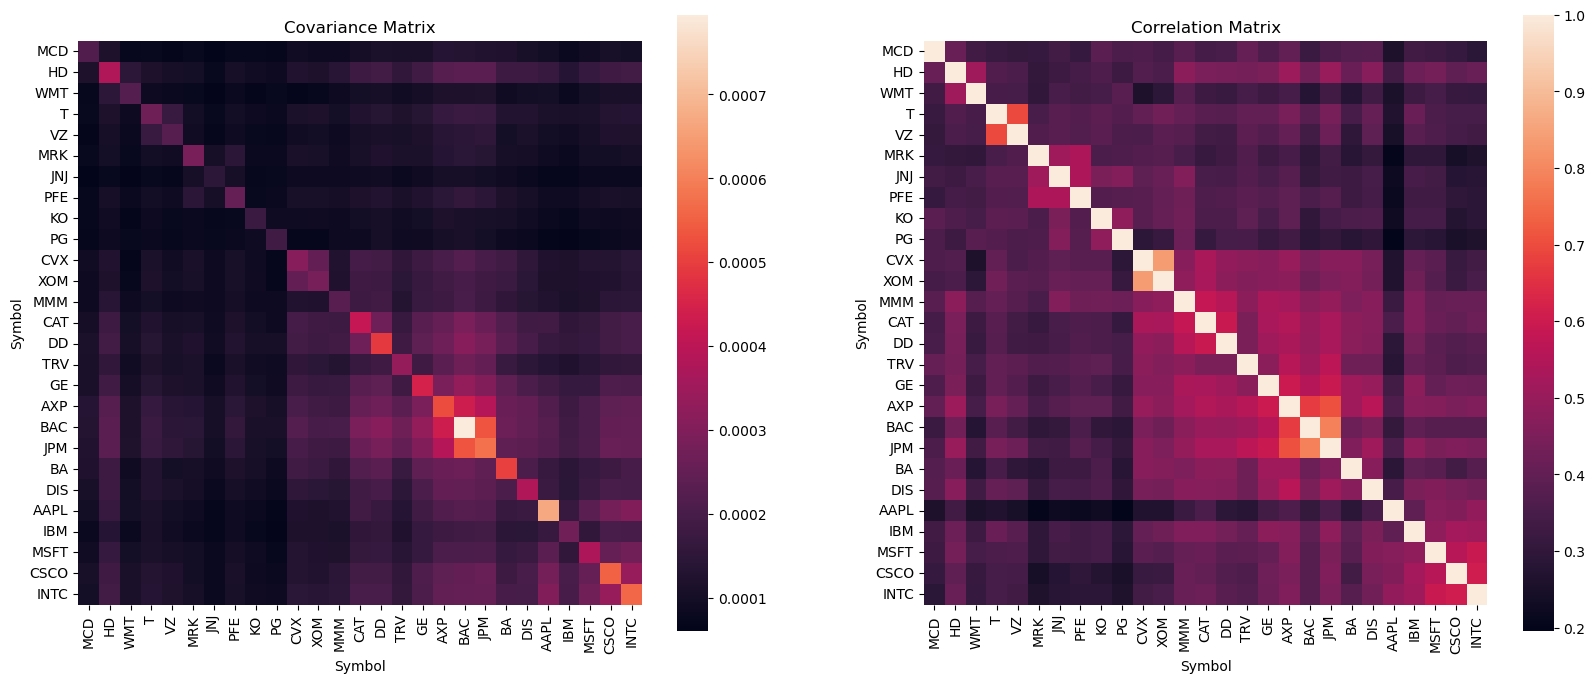

In [73]:
fig, ax = plt.subplots(1, 2, figsize=(20, 8))
sns.heatmap(logret.cov().iloc[ordering, ordering],  square=True, ax=ax[0]).set_title('Covariance Matrix')
sns.heatmap(logret.corr().iloc[ordering, ordering], square=True, ax=ax[1]).set_title('Correlation Matrix')
fig.show()

## Calculate Minimum Variance Portfolio

* $\Sigma$ matrix is all that is specified
* $\Sigma$ characterizes the market
* Minimize variance of portfolio $R_p$

In [74]:
import cvxpy as cvx

s, _ = sigma.shape # calculated from data

w = cvx.Variable(s) # variables
risk = cvx.quad_form(w, sigma.values)  # objective function
prob = cvx.Problem(cvx.Minimize(risk), # optimization problem 
               [cvx.sum(w) == 1])      # fully invested portfolio constraint
prob.solve()

8.479997553120573e-05

In [75]:
w.value

array([ 0.01938583, -0.0708329 , -0.00869833, -0.01214688, -0.00455729,
       -0.01596464,  0.04178972, -0.03793864,  0.01554599, -0.01195571,
       -0.02396555,  0.10211545, -0.01747507,  0.21958877, -0.03110475,
        0.14490991,  0.15145499,  0.08138111,  0.0117678 ,  0.01672814,
        0.03019589,  0.11898728,  0.00600754,  0.01511878,  0.10867189,
        0.13312742,  0.01786327])

* Positive weights indicate long positions
* Negative weights indicate [short positions](https://en.wikipedia.org/wiki/Short_(finance))
* Must sum to 1 (constraint)

* Other portfolio optimization variations:  
    http://nbviewer.jupyter.org/github/cvxgrp/cvx_short_course/blob/master/applications/portfolio_optimization.ipynb

* `cvxpy` package makes it easy to solve many types of problems.
* Portfolio allocation problem with target expected return constraint:

$$ \min_{x\in\mathbb{R}^s}\ \ x^\intercal \Sigma x\\
\text{subject to }\mu^\intercal x\geq \mu^* \text{, and } \mathbf{1}^\intercal x = 1,$$

* Expected returns, $\mu$, is estimated from data (also $\Sigma$)
* Investor specifies target return $\mu^*$

In [76]:
import cvxpy as cvx

s,_ = sigma.shape

w = cvx.Variable(s)
risk = cvx.quad_form(w, sigma.values)
prob = cvx.Problem(cvx.Minimize(risk), 
               [
                   cvx.sum(w) == 1,
                   mu.values@w >= 0.001
               ]) 
prob.solve()

0.0002472038406842972

In [77]:
w.value

array([ 0.37134764, -0.05054319,  0.06071674, -0.15444118,  0.26331449,
       -0.17187413,  0.1671869 , -0.18080102,  0.01227187, -0.35848913,
        0.05243099, -0.08450445, -0.23249379,  0.39510156,  0.16064432,
        0.01950681,  0.36513987,  0.08973753, -0.01886593,  0.14666474,
       -0.09673143,  0.19238984, -0.04574282,  0.16630336, -0.05012627,
       -0.00272693, -0.01541639])

* Higher target return achieved with more short positions
* Constraint: $\mu^\intercal w=0.001$
* Constraint: $\mathbf{1}^\intercal w=1$.

In [78]:
w.value.sum()

1.0000000000000007

In [79]:
np.dot(mu.values,w.value)

0.0009999999999999998

### Making the investment

* Investing 1 dollar in a stock with 3% return over one time period makes me 3 cents:  
    $$\$1 \cdot (1 + 0.03) = 1.03$$
    
* Investing a portfolio of worth $A_0$ dollars returns,
    $$ A = A_0 (1+r_t^T w_t), $$
    where elements of $r_t$ are returns at time $t$ and $w$ is portfolio allocation

* Take allocation `w.value` and compute portfolio returns using historical returns: `logret`.

In [80]:
earned = np.dot(logret.fillna(method='bfill').values, w.value)

* Compute portfolio growth

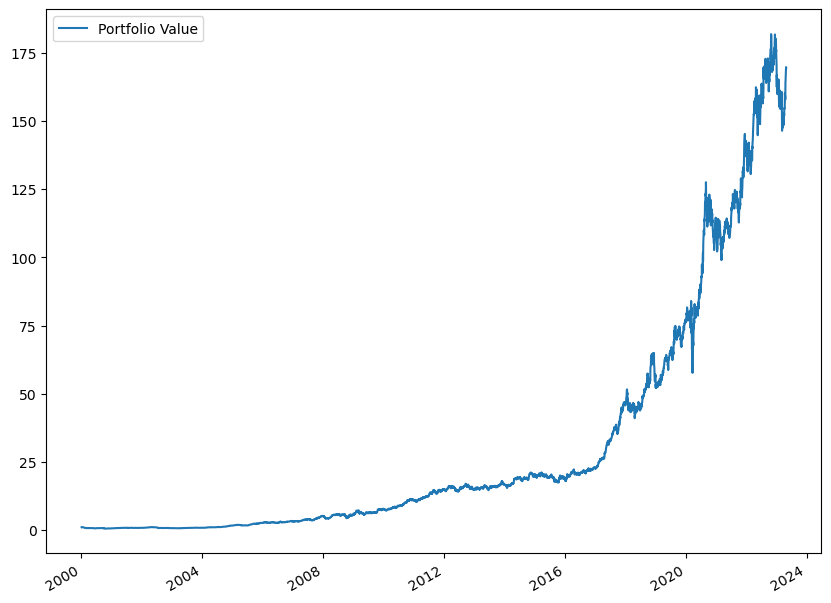

In [81]:
earnedcp = (1+earned[1:]).cumprod()
ecp = pd.DataFrame(data=earnedcp.T, index=logret.index.values[1:], columns=['Portfolio Value'])
ecp.plot(figsize=(10, 8));

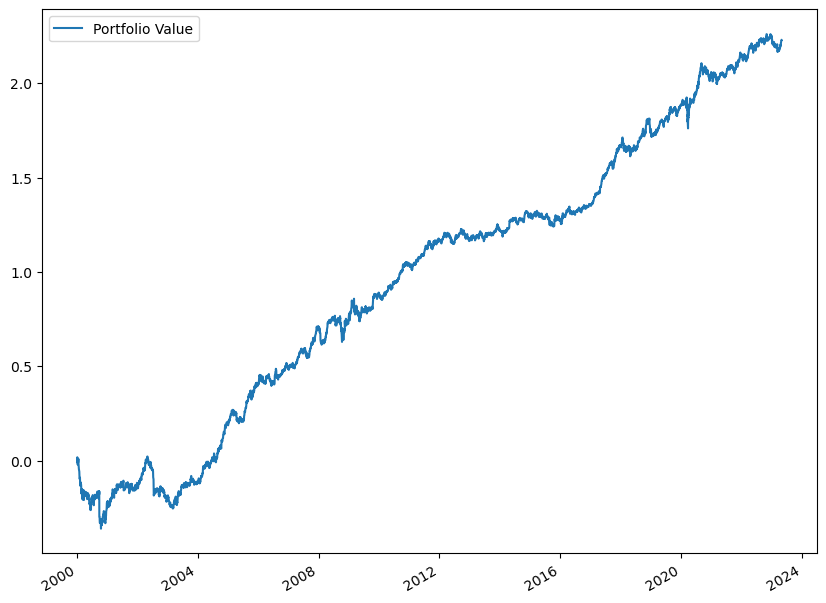

In [82]:
np.log10(ecp).plot(figsize=(10, 8));

In [83]:
ecp

,Portfolio Value
2000-01-04,0.985326
2000-01-05,0.997855
2000-01-06,0.996480
2000-01-07,1.042948
2000-01-10,0.996762
...,...
2023-04-24,166.884076
2023-04-25,167.869475
2023-04-26,168.530741
2023-04-27,169.880811


* 1 dollar invested in 2000 would be 98 dollars today?
* Unrealistic! Why?
* Having knowledge of 20 years worth of data is cheating!

### Quantify results

In [84]:
retinfo = logret.mean(axis=0).agg(['min', 'mean', 'max'])
stdinfo = logret.std(axis=0).agg(['min', 'mean', 'max'])
print('portfolio average returns:', earned.mean())
print('          average stddev :', earned.std())
print('')
print("component stocks average: minimum: %f\n                          average: %f\n                          maximum: %f" % tuple(retinfo))
print("component stocks stddev : minimum: %f\n                          average: %f\n                          maximum: %f" % tuple(stdinfo))

portfolio average returns: 0.0009973288234111255
          average stddev : 0.01572136914913045

component stocks average: minimum: -0.000061
                          average: 0.000267
                          maximum: 0.000903
component stocks stddev : minimum: 0.012216
                          average: 0.018873
                          maximum: 0.028196


Annual return would be:

In [85]:
(1+earned.mean())**365 - 1

0.4388491818835716

Again, unrealistic

### Qualitative Visualization of Relationships

* Correlations are stricly pairwise quantities (what about other stocks?)
* Inverse covariance

In [86]:
from sklearn import preprocessing
scaler = preprocessing.StandardScaler()
scaled_df = scaler.fit_transform(logret.dropna().values)
scaled_df = pd.DataFrame(scaled_df, columns=logret.columns, index=logret.index[1:])

#### Correlation Matrix: 2020

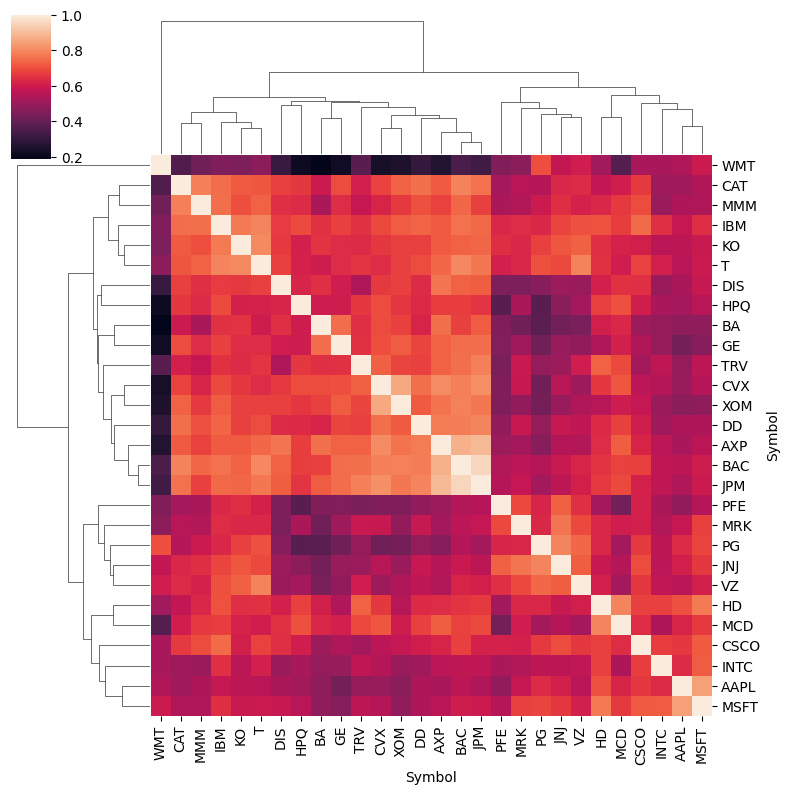

In [170]:
clmap = sns.clustermap(scaled_df.loc['2020':'2020'].corr(), square=True, figsize=(8, 8));
ordering = clmap.dendrogram_col.reordered_ind # save the hierarchical clustering generated variable ordering

#### Correlation Matrix: 2019 vs. 2020

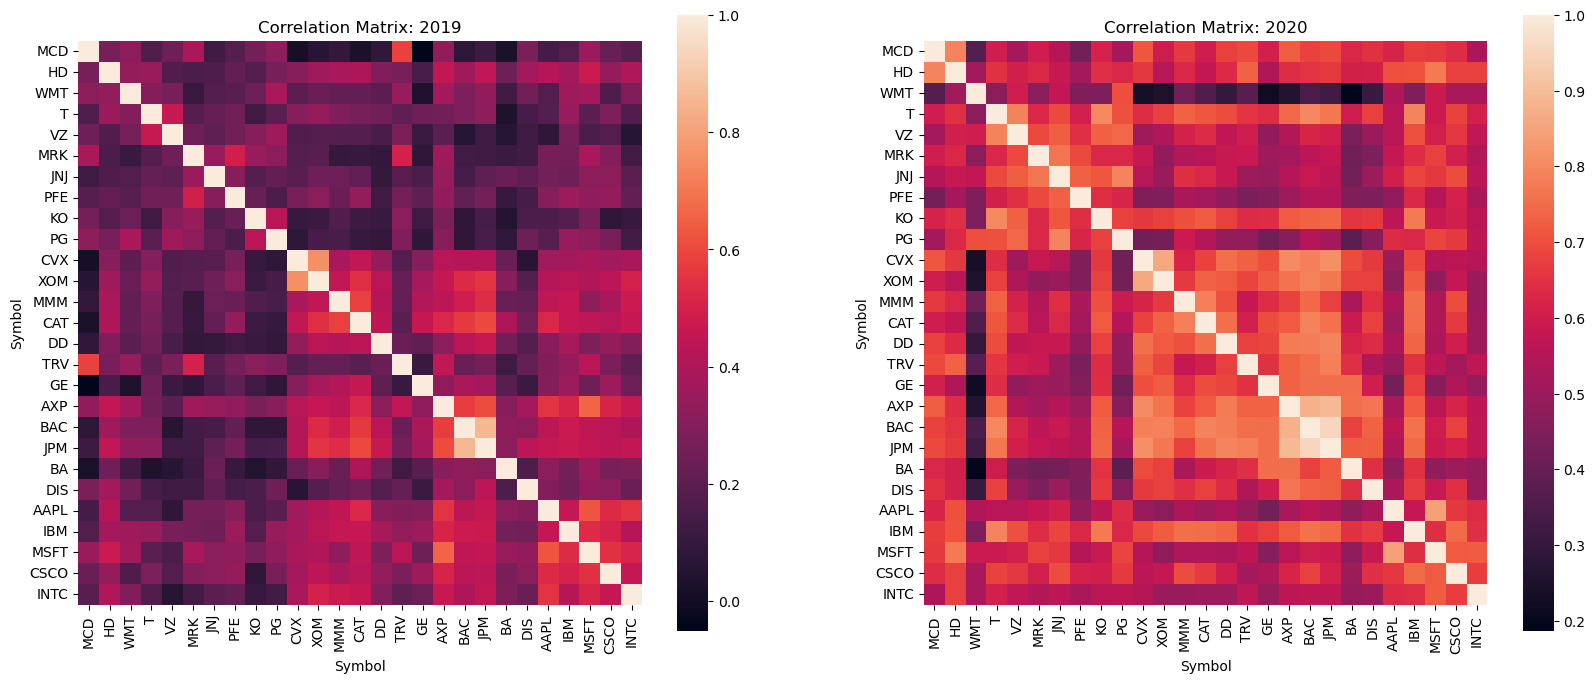

In [87]:
fig, ax = plt.subplots(1, 2, figsize=(20, 8))

sns.heatmap(scaled_df.loc['2019':'2019'].corr().iloc[ordering, ordering],  square=True, ax=ax[0]).set_title('Correlation Matrix: 2019')
sns.heatmap(scaled_df.loc['2020':'2020'].corr().iloc[ordering, ordering],  square=True, ax=ax[1]).set_title('Correlation Matrix: 2020')
fig.show()

### Reality check

Obviously, this cannot be realistic. What aspects were unrealistic?

1. We didn't take time into consideration: e.g. estimation of $\Sigma$ and selecting `w`.
1. We are investing with knowledge of the future returns!
1. We did not take into account transaction costs (we will have to) 
1. We did not take into account shorting requires borrowing of money
1. Is investing in stocks better than leaving our money in a savings account? What is the interest rate?

Sharpe ratio tries to quantify the added benefit, i.e., excess returns, of investing in the volatile market by accounting for the volatility:
$$\text{Sharpe ratio}=\frac{E\left[R_{p}-R_{f}\right]}{\sigma_{p}}$$
where $R_f$ is the risk-free rate.

### Other considerations

1. Picking component stocks (choosing what to invest in)
    1. Playing the role of the fund manager
    1. Expertise about a specific market
    1. Warren Buffet says stick with long term _value_ investing strategies
    1. High-frequency trading makes money by constantly shuffling investments and making incremental returns
    1. Where is the middle ground? i.e., choosing strategies
1. Choosing monitoring strategies (keeping an eye out for changes in the market)
    1. Estimation of $\Sigma$ becomes challenging with shorter historical data
    1. "Regularized" estimates of $\Sigma$: Ledoit-Wolfe, Condition number, Sparsity inducing, Low-rank
    1. How big of a change in the market is signficant change?
    1. Where to look for a change? Component stocks? Market indices? Economic indicators? Consumer sentiment? Policy changes?
    1. Deciding when to take action. How big of a change warrants an action? (Actions cost money)
1. Choosing rebalancing strategy (deciding when to shuffle your investments)  
    1. Fixed intervals? dynamic intervals? 
    1. Allowing for shorts?
    1. If many component stocks, do you trade all of them even if the change is small? etc.

## Other optimization problems for modeling and learning

1. [Online advertising](https://github.com/UCSB-PSTAT-134-234/Spring2019/blob/master/labs/lab05/lab05.ipynb)
1. [Trend filtering](https://web.stanford.edu/~boyd/l1_tf/), [CVX example](https://www.cvxpy.org/examples/applications/l1_trend_filter.html)
1. [Catching a smuggler](https://www.cvxpy.org/examples/applications/interdiction.html)
1. [Estimating sparse inverse covariance matrix](https://www.cvxpy.org/examples/applications/sparse_covariance_est.html)
1. [Max-flow, Min-cut problem](https://www.cvxpy.org/examples/applications/OOCO.html)
1. Many more!!